## Consumo de bebidas - SP

<img src="https://img.jakpost.net/c/2016/08/19/2016_08_19_10034_1471567498._large.jpg" style="height: 400px"/>

Os dados foram coletados em São Paulo (SP), em uma área universitária, onde existem algumas festas com grupos de alunos entre 18 e 28 anos (média). O conjunto de dados utilizado para esta atividade possui 7 atributos, sendo um alvo, com período de um ano.

O objetivo deste kernel é prever o volume de cerveja que será vendido em um dia, através de informações climáticas e econômicas.


- O dataset deste projeto, bem como algumas discussões e kernels estão disponível em https://www.kaggle.com/moriano/predicting-beer-consumption

- Foi-se utilizado também uma série histórica diária do índice Bovespa (`^BVSP`), atual B3, com dados sobre o valor de abertura, fechamento, maior preço do dia etc. Essa séria pode Ser obtida no _Yahoo Finance_: https://finance.yahoo.com/quote/%5EBVSP/history?period1=1420084800&period2=1451534400&interval=1d&filter=history&frequency=1d

In [1]:
%matplotlib inline


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Lê a base principal e faz ajustes no nome e tipo das colunas :

In [2]:
df = pd.read_csv('bases/consumo_cerveja.csv', decimal=',')

# --

df.columns = ["date", "avgTemp", "minTemp", "maxTemp", "rain", "weekend", "litres"]
df.date = pd.to_datetime(df.date, format="%Y-%m-%d")
df.litres = df.litres.astype(float)
df.weekend = df.weekend.astype(bool).astype(int)

# --

df.head()

,date,avgTemp,minTemp,maxTemp,rain,weekend,litres
0,2015-01-01,27.30,23.9,32.5,0.0,0,25.461
1,2015-01-02,27.02,24.5,33.5,0.0,0,28.972
2,2015-01-03,24.82,22.4,29.9,0.0,1,30.814
3,2015-01-04,23.98,21.5,28.6,1.2,1,29.799
4,2015-01-05,23.82,21.0,28.3,0.0,0,28.900


Carrega a série do Ibovespa:

In [3]:
df_b3 = pd.read_csv('bases/bvsp.csv')

# -- 

df_b3.columns = map(str.lower, df_b3.columns)
df_b3.columns = df_b3.columns.str.replace(' ', '_')
df_b3.date = pd.to_datetime(df_b3.date, format="%Y-%m-%d")
df_b3.sort_values('date', inplace=True)

Agora, para cada instância do dataframe `df_b3`, iremos verificar se valor de fechamento do índice é menor ou maior (_i.e._, $-1$ ou $+1$, respectivamente) que do dia anterior mais próximo.

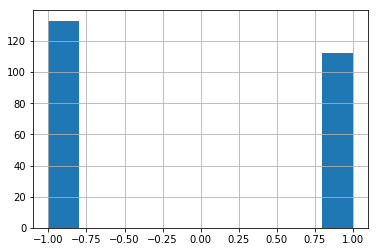

In [4]:
df_b3['b3_var'] = df_b3.close.diff()
df_b3['b3_var'] = df_b3['b3_var'].apply(lambda x: -1 if x < 0 else 1 if x > 1 else np.nan)

# --

df_b3.b3_var.hist()

In [5]:
df_b3.head()

,date,open,high,low,close,adj_close,volume,b3_var
0,2015-01-02,50005.0,50005.0,48345.0,48512.0,48512.0,2882100,NaN
1,2015-01-05,48512.0,48512.0,47264.0,47517.0,47517.0,3866100,-1.0
2,2015-01-06,47517.0,48061.0,47338.0,48001.0,48001.0,4559300,1.0
3,2015-01-07,48006.0,49882.0,48006.0,49463.0,49463.0,4408800,1.0
4,2015-01-08,49463.0,50261.0,49017.0,49943.0,49943.0,3621900,1.0


Iremos colocar a informação de variação no dataframe principal e substituir todos os NaNs por $0$. Essas instâncias podem ser dias onde a bolsa de valores não funcionou (feriados ou finais de semana, por exemplo).

In [6]:
df = df.merge(df_b3[['date', 'b3_var']], how='left', on='date')
df.b3_var.fillna(0, inplace=True)
df.b3_var = df.b3_var.astype(int)

Cria uma coluna informando o dia da semana (Segunda, Terça, ..., Domingo), considerando que a semana começa na segunda-feira (_i.e._, valores entre $0$ (segunda) e $6$ (domingo)). Em seguida, organiza as colunas que serão utilizadas pelo modelo:

In [7]:
df['dayofweek'] = df.date.dt.dayofweek
df['month'] = df.date.dt.month

# --

df = df[["avgTemp", "minTemp", "maxTemp", "rain", "month", "dayofweek", "weekend", "b3_var", "litres"]]

# -- 

print("Dataframe shape:", df.shape)
df.describe()

Dataframe shape: (365, 9)


,avgTemp,minTemp,maxTemp,rain,month,dayofweek,weekend,b3_var,litres
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000
mean,21.226356,17.461370,26.611507,5.196712,6.526027,3.0,0.284932,-0.057534,25.401367
std,3.180108,2.826185,4.317366,12.417844,3.452584,2.0,0.452001,0.818387,4.399143
min,12.900000,10.600000,14.500000,0.000000,1.000000,0.0,0.000000,-1.000000,14.343000
25%,19.020000,15.300000,23.800000,0.000000,4.000000,1.0,0.000000,-1.000000,22.008000
50%,21.380000,17.900000,26.900000,0.000000,7.000000,3.0,0.000000,0.000000,24.867000
75%,23.280000,19.600000,29.400000,3.200000,10.000000,5.0,1.000000,1.000000,28.631000
max,28.860000,24.500000,36.500000,94.800000,12.000000,6.0,1.000000,1.000000,37.937000


Vizualização dos dados:

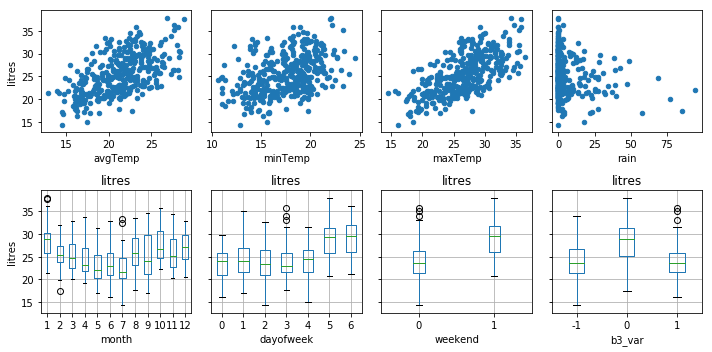

In [8]:
f, ax = plt.subplots(2, 4, figsize=(10, 5), sharey=True)


acum = 0
for i in range(0, 2):
    for j in range(0, 4):
        column = df.columns.tolist()[acum]
        axis = ax[i, j]
        axis.set_title('')
        axis.set_xlabel(column)
        axis.set_ylabel('litres')
        acum += 1
        
        if column in ['avgTemp', 'minTemp', 'maxTemp', 'b3_varrain']:
            df.plot.scatter(column, 'litres', ax=axis)
        else:
            df.boxplot('litres', column, ax=axis)
        

f.suptitle('')
f.tight_layout()

#### Machine Learning

Organização dos dados:

In [9]:
from sklearn.model_selection import train_test_split


X = df.drop('litres', axis=1)
y = df['litres']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [10]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor(n_estimators=150)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [11]:
from sklearn.metrics import mean_squared_error


y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

7.148826081117973

Mostra os atributos mais relevantes para o ensemble:

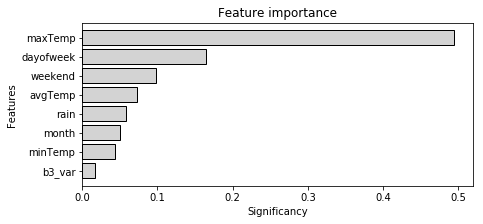

In [12]:
importances, features = zip(*sorted(zip(regr.feature_importances_, X.columns)))

plt.figure(figsize=(7, 3))
plt.title('Feature importance')
plt.ylabel("Features")
plt.xlabel("Significancy")

plt.barh(range(len(features)), importances, align='center', color='lightgray', edgecolor='black')
plt.yticks(range(len(features)), features)

plt.show()